# 專題分析 - 台北市房價分析-Keras

# 1.資料匯入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei' #顯示中文(for Mac)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊
pd.set_option("display.html.table_schema",True)
df_ml = pd.read_csv('tw_house.csv', encoding='big5') #台北市
df_ml.sample(5) #隨機取其中5筆資料

,鄉鎮市區,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,總價元,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
554,內湖區,24.07,175.30,158015,3,2,2,37.25,0,1,105,106,2770.0,0,0,0,1,0,0,0,0,0,0,0,0
216,中山區,2.83,31.01,104805,1,1,1,0.00,0,33,73,106,325.0,1,0,0,0,0,0,0,0,0,0,0,0
293,中山區,0.00,66.74,74318,0,0,1,0.00,0,1,105,106,496.0,1,0,0,0,0,0,0,0,0,0,0,0
525,大同區,18.37,178.95,170718,2,2,2,13.35,0,6,100,106,3055.0,0,0,0,0,0,0,0,1,0,0,0,0
303,松山區,24.53,116.23,189280,2,2,1,0.00,0,25,81,106,2200.0,0,0,0,0,0,0,0,0,0,0,1,0


### 資料處理
#### 切分訓練資料與測試資料 & 將用不到的欄位去除

In [2]:
from sklearn.model_selection import train_test_split

X = df_ml.drop(['鄉鎮市區','總價元'],axis=1) #去除鄉鎮市區、總價元兩個欄位
y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,土地移轉總面積平方公尺,建物移轉總面積平方公尺,單價每平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,車位移轉總面積平方公尺,車位總價元,屋齡,建築完成年,交易年,中山區,中正區,信義區,內湖區,北投區,南港區,士林區,大同區,大安區,文山區,松山區,萬華區
63,23.16,136.41,240653,3,2,2,12.58,1800000,5,101,106,1,0,0,0,0,0,0,0,0,0,0,0
59,69.74,580.76,214022,0,0,0,309.76,15200000,1,105,105,0,0,0,1,0,0,0,0,0,0,0,0
116,24.46,129.78,182617,3,2,2,0.00,0,32,74,106,0,0,0,0,0,0,1,0,0,0,0,0
563,21.79,199.01,150746,3,2,2,38.62,0,3,103,106,0,0,0,0,0,0,0,0,0,1,0,0
415,16.52,107.45,130014,0,0,0,0.00,0,2,104,106,0,0,0,0,1,0,0,0,0,0,0,0


### 標準化

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)

# MLP with Keras

In [4]:
X_train_std.shape

(448, 23)

In [5]:
# Custom Metrics: R Square Score for Keras metrics
import keras.backend as K
def r_squared(y_true, y_pred):
    SS_res = K.sum((y_true - y_pred)**2) 
    SS_tot = K.sum((y_true - K.mean(y_true))**2) 
    return (1 - SS_res/SS_tot)

Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense

# 產生Sequential Model
model = Sequential()

# 增加一層: (hidden)layer=50, input layer=23, 初始weights為常態分佈(normal distribution), activation function為ReLU
model.add(Dense(50, input_dim=23, kernel_initializer='normal',activation='relu'))

# 增加一層: (output)layer=1, weights為常態分佈(normal distribution)
model.add(Dense(1, kernel_initializer='normal'))



# optimizer可使用: sgd, adam, rmsprop, adagrad, adadelta 等 
# 或使用from keras import optimizer設定更詳細參數 (如使用SGD with momentum) https://keras.io/optimizers/
# 建立模型: Loss function為MSE, optimizer為adam
model.compile(loss='mse', optimizer='adam',metrics=[r_squared])

### 模型摘要

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1200      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


### 用history紀錄訓練過程歷史

In [8]:
history = model.fit(X_std, y.values, epochs=500, batch_size=20, validation_split=0.3)

Train on 448 samples, validate on 192 samples
Epoch 1/500
448/448 [==============================] - 0s 526us/step - loss: 9479398.4665 - r_squared: -1.4968 - val_loss: 17836621.2292 - val_r_squared: -1.3719
Epoch 2/500
448/448 [==============================] - 0s 252us/step - loss: 9478160.8359 - r_squared: -1.6145 - val_loss: 17834777.6094 - val_r_squared: -1.3715
Epoch 3/500
448/448 [==============================] - 0s 236us/step - loss: 9476141.3170 - r_squared: -1.4198 - val_loss: 17831513.6510 - val_r_squared: -1.3709
Epoch 4/500
448/448 [==============================] - 0s 242us/step - loss: 9472902.7701 - r_squared: -1.8295 - val_loss: 17826157.3177 - val_r_squared: -1.3699
Epoch 5/500
448/448 [==============================] - 0s 240us/step - loss: 9467387.8705 - r_squared: -1.6632 - val_loss: 17818372.6510 - val_r_squared: -1.3685
Epoch 6/500
448/448 [==============================] - 0s 256us/step - loss: 9459481.2400 - r_squared: -1.7317 - val_loss: 17807330.5885 - val_r

448/448 [==============================] - 0s 270us/step - loss: 6760772.3862 - r_squared: -0.7788 - val_loss: 14237727.1094 - val_r_squared: -0.8153
Epoch 52/500
448/448 [==============================] - 0s 279us/step - loss: 6673824.3371 - r_squared: -0.8757 - val_loss: 14128031.4271 - val_r_squared: -0.7988
Epoch 53/500
448/448 [==============================] - 0s 250us/step - loss: 6589588.1339 - r_squared: -0.7570 - val_loss: 14009433.3229 - val_r_squared: -0.7811
Epoch 54/500
448/448 [==============================] - 0s 244us/step - loss: 6506357.8549 - r_squared: -0.7442 - val_loss: 13882921.0156 - val_r_squared: -0.7624
Epoch 55/500
448/448 [==============================] - 0s 246us/step - loss: 6417041.7980 - r_squared: -0.7499 - val_loss: 13769538.7604 - val_r_squared: -0.7454
Epoch 56/500
448/448 [==============================] - 0s 253us/step - loss: 6334251.7433 - r_squared: -0.6342 - val_loss: 13645986.0938 - val_r_squared: -0.7274
Epoch 57/500
448/448 [=============

448/448 [==============================] - 0s 249us/step - loss: 3151005.8248 - r_squared: 0.1067 - val_loss: 8629307.1146 - val_r_squared: -0.0384
Epoch 102/500
448/448 [==============================] - 0s 245us/step - loss: 3104721.0714 - r_squared: 0.0644 - val_loss: 8537200.4193 - val_r_squared: -0.0265
Epoch 103/500
448/448 [==============================] - 0s 240us/step - loss: 3059291.0379 - r_squared: 0.0171 - val_loss: 8445724.9583 - val_r_squared: -0.0155
Epoch 104/500
448/448 [==============================] - 0s 267us/step - loss: 3014564.4364 - r_squared: 0.1288 - val_loss: 8357348.9271 - val_r_squared: -0.0046
Epoch 105/500
448/448 [==============================] - 0s 250us/step - loss: 2970054.9531 - r_squared: 0.1469 - val_loss: 8269581.8125 - val_r_squared: 0.0063
Epoch 106/500
448/448 [==============================] - 0s 254us/step - loss: 2928950.0603 - r_squared: 0.1781 - val_loss: 8178195.3203 - val_r_squared: 0.0172
Epoch 107/500
448/448 [=====================

Epoch 152/500
448/448 [==============================] - 0s 288us/step - loss: 1873188.8906 - r_squared: 0.4300 - val_loss: 5621325.1693 - val_r_squared: 0.3127
Epoch 153/500
448/448 [==============================] - 0s 316us/step - loss: 1861709.0162 - r_squared: 0.3907 - val_loss: 5590337.8021 - val_r_squared: 0.3164
Epoch 154/500
448/448 [==============================] - 0s 243us/step - loss: 1851043.2204 - r_squared: 0.3664 - val_loss: 5558353.4115 - val_r_squared: 0.3201
Epoch 155/500
448/448 [==============================] - 0s 240us/step - loss: 1840948.9983 - r_squared: 0.4812 - val_loss: 5525615.6380 - val_r_squared: 0.3239
Epoch 156/500
448/448 [==============================] - 0s 241us/step - loss: 1830267.7109 - r_squared: 0.4570 - val_loss: 5493498.3203 - val_r_squared: 0.3277
Epoch 157/500
448/448 [==============================] - 0s 259us/step - loss: 1820007.2422 - r_squared: 0.3290 - val_loss: 5463403.6276 - val_r_squared: 0.3313
Epoch 158/500
448/448 [===========

Epoch 203/500
448/448 [==============================] - 0s 222us/step - loss: 1470641.7871 - r_squared: 0.4577 - val_loss: 4544492.6185 - val_r_squared: 0.4544
Epoch 204/500
448/448 [==============================] - 0s 230us/step - loss: 1464761.8951 - r_squared: 0.4762 - val_loss: 4522639.4740 - val_r_squared: 0.4568
Epoch 205/500
448/448 [==============================] - 0s 255us/step - loss: 1458146.7316 - r_squared: 0.4678 - val_loss: 4513665.8997 - val_r_squared: 0.4589
Epoch 206/500
448/448 [==============================] - 0s 297us/step - loss: 1452146.1024 - r_squared: 0.5691 - val_loss: 4503062.1445 - val_r_squared: 0.4609
Epoch 207/500
448/448 [==============================] - 0s 220us/step - loss: 1445612.3711 - r_squared: 0.5497 - val_loss: 4490729.1953 - val_r_squared: 0.4630
Epoch 208/500
448/448 [==============================] - 0s 233us/step - loss: 1439730.9955 - r_squared: 0.5075 - val_loss: 4473087.1706 - val_r_squared: 0.4651
Epoch 209/500
448/448 [===========

Epoch 254/500
448/448 [==============================] - 0s 329us/step - loss: 1187412.7779 - r_squared: 0.5886 - val_loss: 3991743.1211 - val_r_squared: 0.5476
Epoch 255/500
448/448 [==============================] - 0s 325us/step - loss: 1182810.1119 - r_squared: 0.5618 - val_loss: 3980990.4570 - val_r_squared: 0.5492
Epoch 256/500
448/448 [==============================] - 0s 272us/step - loss: 1178274.2450 - r_squared: 0.5219 - val_loss: 3981999.7604 - val_r_squared: 0.5507
Epoch 257/500
448/448 [==============================] - 0s 320us/step - loss: 1172889.7478 - r_squared: 0.5311 - val_loss: 3971318.7383 - val_r_squared: 0.5522
Epoch 258/500
448/448 [==============================] - 0s 323us/step - loss: 1168280.1445 - r_squared: 0.6118 - val_loss: 3961542.7292 - val_r_squared: 0.5538
Epoch 259/500
448/448 [==============================] - 0s 326us/step - loss: 1163372.4749 - r_squared: 0.5531 - val_loss: 3958760.6536 - val_r_squared: 0.5552
Epoch 260/500
448/448 [===========

Epoch 305/500
448/448 [==============================] - 0s 371us/step - loss: 965348.3245 - r_squared: 0.6299 - val_loss: 3670473.7910 - val_r_squared: 0.6188
Epoch 306/500
448/448 [==============================] - 0s 316us/step - loss: 961660.7171 - r_squared: 0.7085 - val_loss: 3665349.5475 - val_r_squared: 0.6201
Epoch 307/500
448/448 [==============================] - 0s 344us/step - loss: 957907.7266 - r_squared: 0.6875 - val_loss: 3654207.8750 - val_r_squared: 0.6211
Epoch 308/500
448/448 [==============================] - 0s 374us/step - loss: 954066.4039 - r_squared: 0.6550 - val_loss: 3650342.7826 - val_r_squared: 0.6222
Epoch 309/500
448/448 [==============================] - 0s 349us/step - loss: 950558.5840 - r_squared: 0.7334 - val_loss: 3649355.3542 - val_r_squared: 0.6234
Epoch 310/500
448/448 [==============================] - 0s 310us/step - loss: 947120.9743 - r_squared: 0.6749 - val_loss: 3650615.1680 - val_r_squared: 0.6246
Epoch 311/500
448/448 [=================

448/448 [==============================] - 0s 248us/step - loss: 802377.4163 - r_squared: 0.7281 - val_loss: 3451264.4811 - val_r_squared: 0.6747
Epoch 357/500
448/448 [==============================] - 0s 259us/step - loss: 800292.9605 - r_squared: 0.7261 - val_loss: 3441136.8301 - val_r_squared: 0.6757
Epoch 358/500
448/448 [==============================] - 0s 364us/step - loss: 797359.1596 - r_squared: 0.7629 - val_loss: 3442865.2930 - val_r_squared: 0.6766
Epoch 359/500
448/448 [==============================] - 0s 310us/step - loss: 795318.5156 - r_squared: 0.7224 - val_loss: 3446497.4792 - val_r_squared: 0.6775
Epoch 360/500
448/448 [==============================] - 0s 264us/step - loss: 792223.9777 - r_squared: 0.7702 - val_loss: 3438402.5911 - val_r_squared: 0.6784
Epoch 361/500
448/448 [==============================] - 0s 237us/step - loss: 789781.5957 - r_squared: 0.7011 - val_loss: 3439026.2539 - val_r_squared: 0.6793
Epoch 362/500
448/448 [==============================]

448/448 [==============================] - 0s 325us/step - loss: 695318.4201 - r_squared: 0.7784 - val_loss: 3301353.0059 - val_r_squared: 0.7151
Epoch 408/500
448/448 [==============================] - 0s 250us/step - loss: 693295.1769 - r_squared: 0.7602 - val_loss: 3315711.8949 - val_r_squared: 0.7156
Epoch 409/500
448/448 [==============================] - 0s 242us/step - loss: 692862.6385 - r_squared: 0.8208 - val_loss: 3322510.8923 - val_r_squared: 0.7161
Epoch 410/500
448/448 [==============================] - 0s 248us/step - loss: 690450.2030 - r_squared: 0.7675 - val_loss: 3314458.4235 - val_r_squared: 0.7170
Epoch 411/500
448/448 [==============================] - 0s 245us/step - loss: 688899.6897 - r_squared: 0.8147 - val_loss: 3315351.5911 - val_r_squared: 0.7175
Epoch 412/500
448/448 [==============================] - 0s 246us/step - loss: 687748.3977 - r_squared: 0.7670 - val_loss: 3306800.3411 - val_r_squared: 0.7180
Epoch 413/500
448/448 [==============================]

448/448 [==============================] - 0s 300us/step - loss: 623830.0466 - r_squared: 0.7858 - val_loss: 3189721.4922 - val_r_squared: 0.7439
Epoch 459/500
448/448 [==============================] - 0s 301us/step - loss: 622795.8152 - r_squared: 0.7916 - val_loss: 3191016.4033 - val_r_squared: 0.7445
Epoch 460/500
448/448 [==============================] - 0s 321us/step - loss: 621330.4332 - r_squared: 0.8270 - val_loss: 3187440.0251 - val_r_squared: 0.7450
Epoch 461/500
448/448 [==============================] - 0s 278us/step - loss: 620409.4159 - r_squared: 0.7696 - val_loss: 3185380.0563 - val_r_squared: 0.7452
Epoch 462/500
448/448 [==============================] - 0s 276us/step - loss: 618965.6327 - r_squared: 0.7961 - val_loss: 3179429.6745 - val_r_squared: 0.7458
Epoch 463/500
448/448 [==============================] - 0s 271us/step - loss: 618178.6529 - r_squared: 0.8135 - val_loss: 3178337.4967 - val_r_squared: 0.7463
Epoch 464/500
448/448 [==============================]

In [9]:
history.history.items()

dict_items([('loss', [9479398.4665178563, 9478160.8359375, 9476141.3169642854, 9472902.7700892854, 9467387.8705357146, 9459481.2399553563, 9449537.390625, 9435846.4508928563, 9418943.1227678563, 9398881.0111607146, 9376865.9151785709, 9350582.03125, 9322557.6986607146, 9290613.9441964291, 9256588.3482142854, 9219474.6339285709, 9178182.4821428563, 9134477.9441964291, 9090394.15625, 9042564.9732142854, 8990673.6897321437, 8938880.6116071437, 8884938.5022321437, 8828013.1629464291, 8768302.8270089291, 8706910.5959821437, 8643920.90625, 8580518.1607142854, 8511380.4330357146, 8449181.8816964291, 8378157.5736607146, 8309276.0669642854, 8236322.2477678573, 8162475.9642857146, 8086727.2566964282, 8012842.4285714282, 7927416.1004464282, 7849990.3939732146, 7769742.1138392854, 7690930.359375, 7607419.3035714282, 7524473.4553571427, 7441356.8683035718, 7358730.4352678573, 7270266.1674107146, 7187439.9241071427, 7103657.6919642854, 7018477.1964285718, 6932248.7209821427, 6847892.5, 6760772.38616

In [10]:
history.history.get('val_r_squared')

[-1.3718989491462708,
 -1.3715156962474186,
 -1.3708870162566502,
 -1.3699029783407848,
 -1.3684606775641441,
 -1.3665190041065216,
 -1.3638973409930866,
 -1.3607696766654651,
 -1.3570801218350728,
 -1.3527035315831502,
 -1.3476224417487781,
 -1.3421086867650349,
 -1.3358533556262653,
 -1.3293319667379062,
 -1.3221318696935971,
 -1.3141709839304287,
 -1.3057088156541188,
 -1.2967492192983627,
 -1.2873833750685055,
 -1.277495875954628,
 -1.267766331632932,
 -1.2568084374070168,
 -1.2456098347902298,
 -1.2339331681529682,
 -1.221769243478775,
 -1.2094434027870495,
 -1.1970475241541862,
 -1.1836698005596797,
 -1.1711428662141163,
 -1.1566326593359311,
 -1.1428755819797516,
 -1.1284904877344768,
 -1.1143262634674709,
 -1.1001391584674518,
 -1.0846436644593875,
 -1.0680176441868146,
 -1.0532257085045178,
 -1.0362935786445935,
 -1.0199748774369557,
 -1.0031285857160885,
 -0.98700631161530816,
 -0.97134450078010559,
 -0.95448249330123269,
 -0.93690801411867142,
 -0.91965669145186746,
 -0.9021

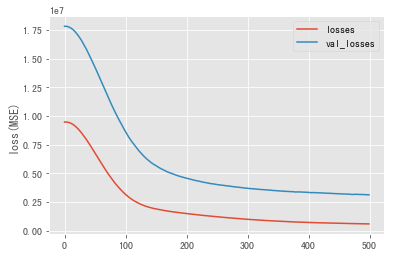

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
losses = history.history.get('loss')
val_losses = history.history.get('val_loss')
x = [i for i in range(len(losses))]
plt.plot(x, losses, label='losses')
plt.plot(x, val_losses, label='val_losses')
plt.ylabel('loss(MSE)')
plt.legend()
plt.show()

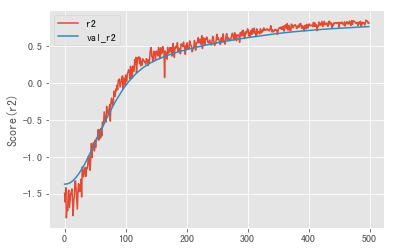

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
r2 = history.history.get('r_squared')
val_r2 = history.history.get('val_r_squared')
x = [i for i in range(len(r2))]
plt.plot(x, r2, label='r2')
plt.plot(x, val_r2, label='val_r2')
plt.ylabel('Score(r2)')
plt.legend()
plt.show()

In [13]:
model.evaluate(X_test_std, y_test.values, batch_size=192)

192/192 [==============================] - 0s 18us/step


[1843644.375, 0.79649913311004639]

# LinearRegression (作為Baseline比較)

In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np

lr = LinearRegression()
lr.fit(X_train_std, y_train)

print('各變項參數:', lr.coef_)
print("MSE: %.2f" % np.mean((lr.predict(X_test_std) - y_test) ** 2))
print("R Square:",lr.score(X_test_std, y_test))

各變項參數: [[ -1.93074148e+02   2.19653384e+03   7.93802357e+02   1.14701901e+01
   -4.51533289e+01  -7.72985153e+01  -4.87091681e+02   4.16178008e+02
    3.75934443e+01  -3.75934443e+01   4.09470356e+01   9.27216298e+00
    1.85358266e+00  -5.37834507e+01  -2.87020540e+01  -5.53966078e+00
   -1.76259076e+01   7.66334021e+01   6.84733404e+00   5.81640113e+01
   -1.36881360e+01  -5.59635083e+01   3.17201413e+01]]
MSE: 952050.17
R Square: 0.894912996258


In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_std, y, cv=5, scoring='neg_mean_squared_error')
np.mean(scores*-1)

1281671.2283246296

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_std, y, cv=5, scoring='r2')
np.mean(scores)

0.8188903184052897

# Keras + sklearn Kfold

In [17]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Loss(MSE)")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


In [18]:
def MLP_model():
    model = Sequential()
    model.add(Dense(50, input_dim=23, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mse', optimizer='adam')

    return model

Epoch 1/1
115/115 [==============================] - 0s 243us/step
Epoch 1/1
230/230 [==============================] - 0s 262us/step
Epoch 1/1
345/345 [==============================] - 0s 153us/step
Epoch 1/1
460/460 [==============================] - 0s 223us/step
Epoch 1/1
576/576 [==============================] - 0s 127us/step
Epoch 1/1
115/115 [==============================] - 0s 215us/step
Epoch 1/1
230/230 [==============================] - 0s 176us/step
Epoch 1/1
345/345 [==============================] - 0s 137us/step
Epoch 1/1
460/460 [==============================] - 0s 173us/step
Epoch 1/1
576/576 [==============================] - 0s 171us/step
Epoch 1/1
115/115 [==============================] - 0s 204us/step
Epoch 1/1
230/230 [==============================] - 0s 159us/step
Epoch 1/1
345/345 [==============================] - 0s 172us/step
Epoch 1/1
460/460 [==============================] - 0s 163us/step
Epoch 1/1
576/576 [==============================] - 0s 143us/

230/230 [==============================] - 0s 376us/step
Epoch 1/1
345/345 [==============================] - 0s 213us/step
Epoch 1/1
460/460 [==============================] - 0s 211us/step
Epoch 1/1
576/576 [==============================] - 0s 202us/step
Epoch 1/1
115/115 [==============================] - 0s 300us/step
Epoch 1/1
230/230 [==============================] - 0s 228us/step
Epoch 1/1
345/345 [==============================] - 0s 332us/step
Epoch 1/1
460/460 [==============================] - 0s 256us/step
Epoch 1/1
576/576 [==============================] - 0s 242us/step


<module 'matplotlib.pyplot' from '/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/pyplot.py'>

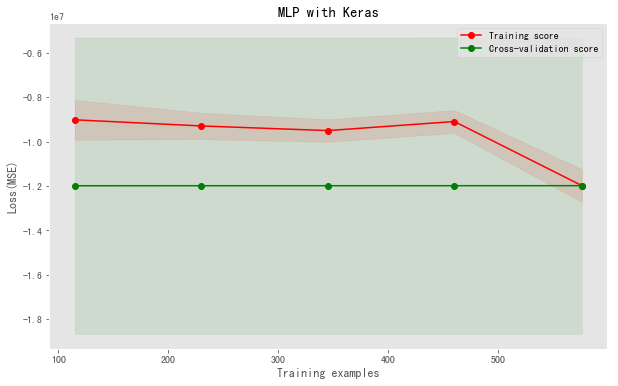

In [19]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=None, shuffle=True)
estimator = KerasRegressor(build_fn=MLP_model, nb_epoch=10, batch_size=10)

plot_learning_curve(estimator, "MLP with Keras", X_std, y.values, cv=cv, train_sizes=np.linspace(0.2, 1.0, 5))

## 結論

### 當資料量還不夠龐大的時候,機器學習演算法所得到的預測結果還是比deep learning來得較佳

### 建模與執行的時間也較為快速